<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) for UW's [Astro 599](http://www.astro.washington.edu/users/vanderplas/Astr599/) course. Source and license info is on [GitHub](https://github.com/jakevdp/2013_fall_ASTR599/).</i></small>

# Matplotlib In-depth

We've discussed some of the basic interface to matplotlib plots previously.  Here we'll go a bit more in-depth, and discuss things like multi-panel plots, inset plots, axes formatting, and much more.

To see the way the Matplotlib code is organized, see the github repository here: https://github.com/matplotlib/matplotlib/tree/master/lib/matplotlib

## Summary

1. Matplotlib in the IPython notebook
2. Matplotlib's two interfaces: scripted and object-oriented
3. Layouts: four ways to create multi-panel plots
4. Formatters & Locators: customizing your axis labels
5. Global settings: the matplotlibrc file

## Matplotlib in the IPython notebook

IPython has a ``pylab`` mode and (in version 1.0+) a ``matplotlib`` mode.  Whenever you're doing plotting in IPython, you should enable one of these.

Adding the ``inline`` flag will use the appropriate backend to make figures appear inline in the notebook.  Otherwise, figures will pop-out in separate windows.

#### Two ways to enable:

1. At the command line, type
   ```
   [~]$ ipython --pylab
   ```
   
   or, in version 1.0+,
   
   ```
   [~]$ ipython --matplotlib
   ```
   
2. Within the notebook or IPython command-line, type
   ```
   In[]: %pylab inline
   ```
   
   or
   
   ```
   In[]: %matplotlib inline
   ```     
   
The difference between ``pylab`` mode and ``matplotlib`` mode is that ``pylab`` includes a bunch of silent imports, including

     import numpy as np
     import matplotlib.pyplot as plt
     from pylab import *

This can be convenient, but is often confusing (for example, it replaces the builtin ``sum()`` function with numpy's ``sum()``!).  For that reason we'll use ``matplotlib`` mode.  If your IPython version is older than 1.0, you'll have to switch this to ``pylab`` mode.

In [1]:
# check the IPython version
import IPython
print IPython.__version__

4.0.0


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Matplotlib: Scripted vs. Object Oriented

Matplotlib provides two flavors of interface.  One is the scripted interface, designed to feel like Matlab.  To enable this, matplotlib maintains a pointer to the current figure, current axis, etc. and directs top-level commands to those places:

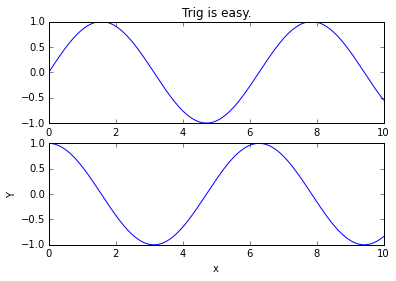

In [31]:
# create a figure using the matlab-like interface
x = np.linspace(0, 10, 1000)
plt.subplot(2, 1, 1)  # 2x1 grid, first plot
plt.plot(x, np.sin(x))
plt.title('Trig is easy.')

plt.subplot(2, 1, 2)  # 2x1 grid, second plot
plt.plot(x, np.cos(x))
plt.xlabel('x')
plt.ylabel('Y')

The other interface is an object-oriented interface, where we expliticly pass around references to the plot elements we want to work with:

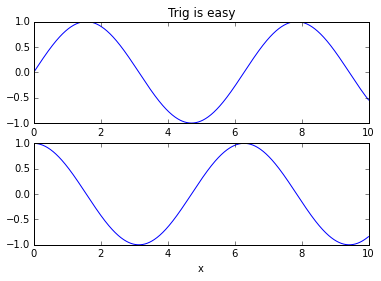

In [7]:
# create the same figure using the object-oriented interface
fig = plt.figure()

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(x, np.sin(x))
ax1.set_title("Trig is easy")

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(x, np.cos(x))
ax2.set_xlabel('x')

### Why use one interface vs another?

These two interfaces are convenient for different circumstances.  I find that for doing quick, simple plots, the scripted interface is often easiest.  On the other hand, when I want more sophisticated plots, the object-oriented interface is simpler and more powerful.  In fact, the scripted interface has several distinct limitations.

**It's good practice to use the object-oriented interface.**
That is, you should get in the habit of never using the ``plt.<command>`` when you can reference a specific axes or figure object instead.

## Multi-panel plots

There are four main ways to create multi-panel plots in matplotlib.  From lowest to highest-level they are (roughly):

1. ``fig.add_axes()``: useful for creating inset plots.
2. ``fig.add_subplot()``: useful for simple multi-panel plots.
3. ``plt.subplots()``: convenience function to create multiple subplots.
4. ``plt.GridSpec()``: useful for more involved layouts.

### 1. ``fig.add_axes()``

The ``add_axes`` method allows you to create an axes instance by specifying the size relative to the figure edges.

The argument is ``[left, bottom, width, height]`` which specifies the axes extent in fractions of the figure size (i.e. between 0 and 1):

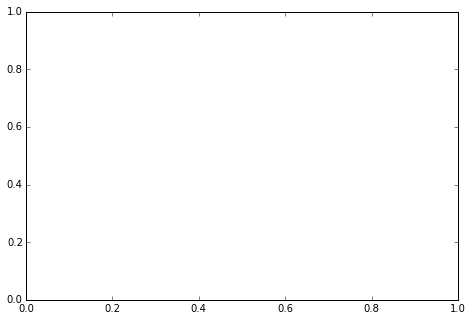

In [20]:
fig = plt.figure()
main_ax = fig.add_axes([0, 0, 1, 1])

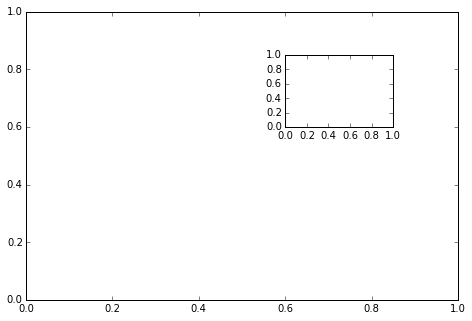

In [21]:
inset_ax = fig.add_axes([0.6, 0.6, 0.25, 0.25])
fig

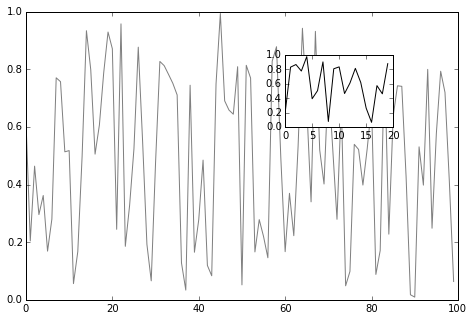

In [22]:
main_ax.plot(np.random.rand(100), color='gray')
inset_ax.plot(np.random.rand(20), color='black')
fig

### 2. ``fig.add_subplot()``

If you're trying to create multiple axes in a grid, you might use ``add_axes()`` repeatedly, but calculating the extent for each axes is not trivial.  The ``add_subplot()`` method can streamline this.

The arguments are of the form ``N_vertical, N_horizontal, Plot_number``, and the indices start at 1 (a holdover from Matlab):

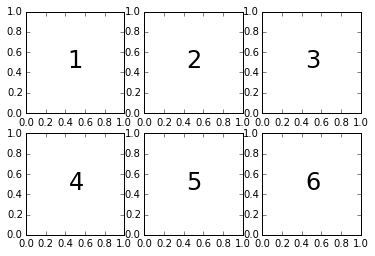

In [23]:
fig = plt.figure()
for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i)
    ax.text(0.45, 0.45, str(i), fontsize=24)

If you desire, you can adjust the spacing using ``fig.subplots_adjust()``, with units relative to the figure size (i.e. between 0 and 1)

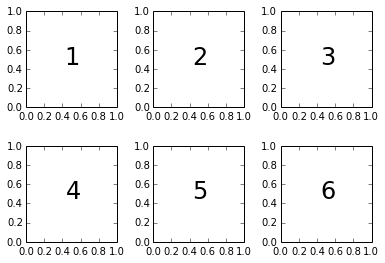

In [10]:
fig.subplots_adjust(left=0.1, right=0.9,
                    bottom=0.1, top=0.9,
                    hspace=0.4, wspace=0.4)
fig

### 3. ``plt.subplots()``

because creating a full grid of subplots is such a common task, matplotlib recently added the ``plt.subplots()`` command which creates the figure and axes in one go.

The arguments are ``N_vertical``, ``N_horizontal``, and the axes are returned within a Numpy array:

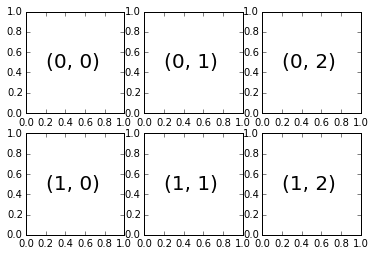

In [24]:
fig, ax = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        ax[i, j].text(0.2, 0.45, str((i, j)), fontsize=20)

In [27]:
print type(ax)
print ax.shape
print ax.dtype

<type 'numpy.ndarray'>
(2, 3)
object


An additional nice piece of this routine is the ability to specify that the subplots have a shared ``x`` or ``y`` axis: this ties together the axis limits and removes redundant tick labels:

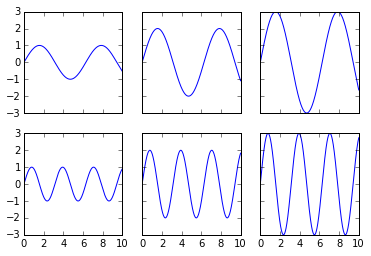

In [28]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
x = np.linspace(0, 10, 1000)
for i in range(2):
    for j in range(3):
        ax[i, j].plot(x, (j + 1) * np.sin((i + 1) * x))

### 4. ``plt.GridSpec()``

``GridSpec`` is the highest-level routine for creating subplots.  It's an abstract object that allows the creation of multi-row or multi-column subplots via an intuitive slicing interface:

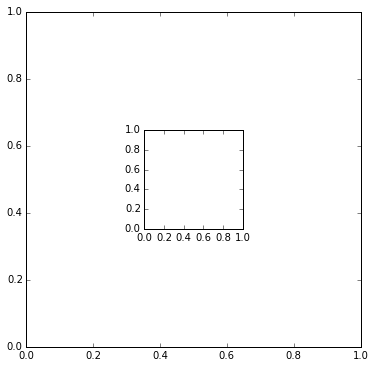

In [32]:
gs = plt.GridSpec(3, 3)  # a 3x3 grid
fig = plt.figure(figsize=(6, 6))  # figure size in inches

fig.add_subplot(gs[:, :])
fig.add_subplot(gs[1, 1])

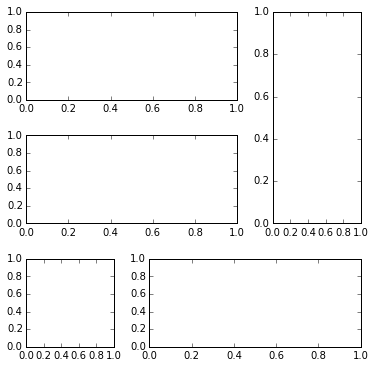

In [33]:
gs = plt.GridSpec(3, 3, wspace=0.4, hspace=0.4)
fig = plt.figure(figsize=(6, 6))

fig.add_subplot(gs[1, :2])
fig.add_subplot(gs[0, :2])
fig.add_subplot(gs[2, 0])
fig.add_subplot(gs[:2, 2])
fig.add_subplot(gs[2, 1:])

Check out the documentation of ``plt.GridSpec`` for information on adjusting the subplot parameters.  The keyword arguments are similar to those of ``plt.subplots_adjust()``.

### Quick Exercise:
#### Visualizing multi-dimensional correlations

Let's use a multi-panel plot to show the correlations between three different variables.  Here's an example of the type of plot we'd like to create:

<img src="http://www.astroml.org/_images/fig_LINEAR_sample_1.png" width="60%">

([source](http://www.astroml.org/book_figures/chapter1/fig_LINEAR_sample.html))

Ignore the upper-right panel for the time-being.  The point is that there are three variables this plot compares: period, ``g-r`` color, and ``r-i`` color.  By comparing the three panels, we gain some excellent intuition into the correlations between the three variables.

Your task: use the ``asteroids5000.csv`` data from the previous breakout session, and plot the semi-major axis, the ellipticity, and the inclination angle in the same manner.  Note that these are, respectively, columns (1, 2, 3) in the file.

(Recall that the asteroids file can be found in the github repository, at ``notebooks/data/asteroids5000.csv``, and you can load the data using ``np.genfromtxt``).

## Formatters and Locators:
##Customizing your axes

This is another important piece of producing publication-quality plots: adjusting your axis ticks and tick labels.  These are done through ``plt.Formatter`` and ``plt.Locator`` objects.

- ``Formatter``, as you might imagine, adjust the **format** of the tick labels.
- ``Locator`` adjusts the **location** of the tick labels.

Additionally, you should be aware that matplotlib has two classes of ticks:  **major** ticks, and **minor** ticks.

### Formatters

Here's an example of adjusting the formatter of the tick labels

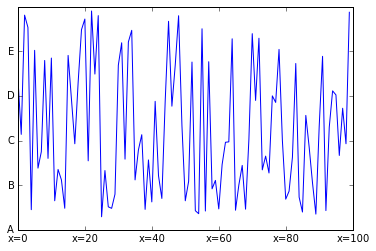

In [37]:
fig, ax = plt.subplots()  # trick to create a single axes
ax.plot(np.random.rand(100))

# set the major formatter for the x-axis
ax.xaxis.set_major_formatter(plt.FormatStrFormatter("x=%i"))

# set the major formatter for the y-axis
ax.yaxis.set_major_formatter(plt.FixedFormatter(['A', 'B', 'C', 'D','E']))

We see the general form used to set these.  We first get the ``axis`` instance (not to be confused with the ``axes`` instance), then call the ``set_major_formatter`` or ``set_minor_formatter`` method, and pass a ``Formatter`` object.

#### Available Formatters

The following formatters are available:

- ``plt.ScalarFormatter``: default -- choose the best format
- ``plt.LogFormatter``: default for log plots
- ``plt.NullFormatter``: no tick labels
- ``plt.FixedFormatter``: a fixed list of tick labels
- ``plt.FuncFormatter``: a function which returns a label
- ``plt.FormatStrFormatter``: label derived from a format string

Note that several of these formatters make the most sense when being used along with a custom locator.

The ``FuncFormatter`` can be especially useful:

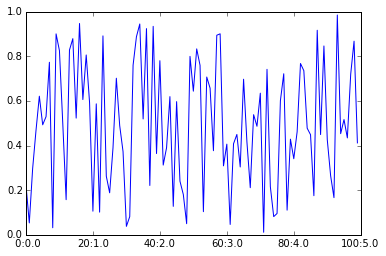

In [38]:
fig, ax = plt.subplots()  # trick to create a single axes
ax.plot(np.random.rand(100))

def formatfunc(tick_loc, tick_num):
    return '%2d:%2.1f'%(tick_loc, tick_num)

# set the major formatter for the x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(formatfunc))

### Locators

Locators are used in a similar manner to formatters:

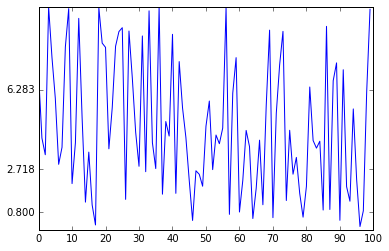

In [42]:
fig, ax = plt.subplots()
ax.plot(10 * np.random.rand(100))

ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_major_locator(plt.FixedLocator([np.e, 2 * np.pi, 0.8]))

#### Available Locators

The following Locators are available:

- ``plt.LinearLocator``: default: choose a suitable linear spacing
- ``plt.LogLocator``: default for log plots: choose a suitable logarithmic spacing.
- ``plt.IndexLocator``: default for index plots (where ``x = range(len(y))``)
- ``plt.NullLocator``: no ticks (this is the default for minor ticks)
- ``plt.FixedLocator``: specify fixed tick locations
- ``plt.MultipleLocator``: ticks at a multiple of the given number

### Quick Exercises

For the first four exercises below, use ``plot(x, y)`` where ``x`` ranges from 0 to 10 and ``y = sin(x)``.

1. Create a plot with no ticks and no labels

2. Create a plot with ticks but no labels

3. Create a plot where the x labels are in multiples of pi

4. Redo #3, but use a ``FuncFormatter`` to make the labels appear as $\pi$, $2\pi$, $3\pi$, etc.  Note that latex math expressions are denoted by dollar signs, but you'll usually need raw strings: e.g. ``r'$\pi$'`` renders to $\pi$

5. Log scaling can be turned on by using, e.g.
   ```
   fig = plt.figure()
   ax = fig.add_subplot(1, 1, 1, xscale='log')
   ax.plot(...)
   ```
   Make a log-log plot of the function $y = x^2$ where x ranges from 1 to 10.
   
6. Repeat plot #5, but change the axes so that the major ticks are powers of 2 rather than powers of 10.  Turn the minor ticks off.

## System-wide formatting: matplotlibrc

Matplotlib is extremely customizable.  You can change the default of many different components using the ``matplotlibrc`` file, located at ``~/.matplotlib/matplotlibrc``.  If the file doesn't exist, then default settings are used.  You can see a template matplotlibrc file [here](http://matplotlib.org/users/customizing.html#matplotlibrc-sample):

In [18]:
#%load http://matplotlib.org/_static/matplotlibrc

#### Setting params dynamically

Additionally, if you'd just like to change parameters for the current python session, you can use the ``plt.rc`` function to dynamically set them.

The ``plt.rc`` function has the following signature:

    rc(element_name, attr1=val1, attr2=val2)

and the results will be stored in the ``plt.rcParams`` dictionary:

In [19]:
print plt.rcParams['lines.linewidth']

1.0


In [20]:
plt.rc('lines', linewidth=5.0)
print plt.rcParams['lines.linewidth']

5.0


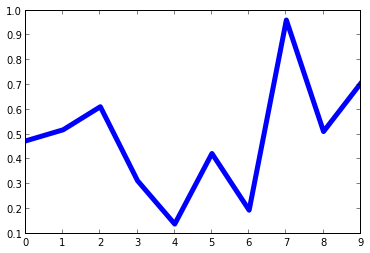

In [21]:
plt.plot(np.random.rand(10))

You can examine all the possible rcParams values by printing the keys of the rcParams dictionary.

In [22]:
plt.rcParams.keys()[:5]

['agg.path.chunksize',
 'animation.bitrate',
 'animation.codec',
 'animation.ffmpeg_args',
 'animation.ffmpeg_path']